<a href="https://colab.research.google.com/github/NBELab/PLoS_Comp_2022/blob/main/notebooks/color_perception_model_nengo_21_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import scipy
import scipy.ndimage
import scipy.ndimage.filters

import nengo
from nengo.dists import Uniform

In [ ]:
!pip install nengo nengo-ocl

In [ ]:
#convert RGB image to gray level
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray
   
#convert RGB image to opponent channels
def rgb2opp(rgb):
  R, G, B = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  O3 = rgb2gray(rgb)
  O1 = (R-G)/np.sqrt(2)
  O2 = (R + G - 2*B)/np.sqrt(6)
  return np.stack((O1,O2,O3),axis =-1)

#convert opponet channels back to RGB image  
def opp2rgb(opp):
  a = 0.2989;
  b = 0.587;
  c = 0.114;

  O1, O2, O3 = opp[:,:,0], opp[:,:,1], opp[:,:,2]

  B = (O3-np.sqrt(2)/2*(a-b)*O1 - np.sqrt(6)/2*(a+b)*O2) / (a+b+c);
  G = (np.sqrt(6)*O2-np.sqrt(2)*O1+2*B)/2;
  R = np.sqrt(2)*O1+G;

  return np.stack((R,G,B),axis =-1)

# spatial gaussian filter
def fspecial_gauss(size, sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """

    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

In [ ]:

kernel = fspecial_gauss(21,5)
h = 90
w = 120

# 2d convulotion layer 
def conv_filter2d(kernel,n_neurons_ens =2):
    filter = kernel[:,:,None,None] 
    conv = nengo.Convolution(n_filters =1, input_shape=(h,w,1), kernel_size=tuple([kernel.shape[0],kernel.shape[1]]),  strides=tuple([1,1]),  padding='same', channels_last=True,init= filter)

    if(n_neurons_ens == 2):
    
      layer = nengo.networks.EnsembleArray(n_neurons_ens, conv.output_shape.size,                                         
                                          intercepts=Uniform(0, 0),
                                          max_rates=Uniform(200, 200),
                                          encoders=[[1],[-1]],
                                          neuron_type= nengo.SpikingRectifiedLinear()
                                          )
    else:
      layer = nengo.networks.EnsembleArray(n_neurons_ens, conv.output_shape.size,                                         
                                          intercepts=Uniform(0, 0),
                                          max_rates=Uniform(100, 200),                                          
                                          neuron_type= nengo.SpikingRectifiedLinear()
                                          )

                      
    return layer,conv

# single opponent pathway, each opponent input is convolved with spatial gaussian filter (definded by kernel)
def color_network():
  with nengo.Network() as net:

    o1_ens = nengo.networks.EnsembleArray(
        2,
        h*w,         
        intercepts=Uniform(0, 0),       
        max_rates=Uniform(200, 200),       
        encoders=[[1],[-1]],
        neuron_type=nengo.SpikingRectifiedLinear()
    )
    o2_ens = nengo.networks.EnsembleArray(
        2,
        h*w,         
        intercepts=Uniform(0, 0),       
        max_rates=Uniform(200, 200),       
        encoders=[[1],[-1]],
        neuron_type=nengo.SpikingRectifiedLinear()
    )    
    o3_ens = nengo.networks.EnsembleArray(
        2,
        h*w,         
        intercepts=Uniform(0, 0),       
        max_rates=Uniform(200, 200),       
        encoders=[[1],[-1]],
        neuron_type=nengo.SpikingRectifiedLinear()
    )
    net.diff1,conv = conv_filter2d(kernel)
    net.diff2,conv = conv_filter2d(kernel)
    net.diff3,conv = conv_filter2d(kernel)
    net.O1 = nengo.Node(size_in=n)
    net.O2 = nengo.Node(size_in=n)
    net.O3 = nengo.Node(size_in=n)
   

    nengo.Connection(net.O1, o1_ens.input,synapse=None)
    nengo.Connection(net.O2, o2_ens.input,synapse=None)
    nengo.Connection(net.O3, o3_ens.input,synapse=None)
   

    nengo.Connection(o1_ens.output, net.diff1.input,transform=conv,synapse=None)
    nengo.Connection(o2_ens.output, net.diff2.input,transform=conv,synapse=None)
    nengo.Connection(o3_ens.output, net.diff3.input,transform=conv,synapse=None)


  return net

# LaplaceNet recurcivlly reconstucts image - double opponent pathway
def LaplaceNet(number_neurons=2):
  
  tau = 1/4
  
  w_filter = tau* np.array([[0, 1, 0], [1, -4, 1],[0, 1, 0]])
  
  n = 90*120
  
 
  with nengo.Network() as laplaceSolver:

    laplaceSolver.input =  nengo.Node(size_in=n)
  
    layer_on,conv_on = conv_filter2d(w_filter,number_neurons)
  
    nengo.Connection(laplaceSolver.input, layer_on.input,transform=tau)   
    nengo.Connection(layer_on.output, layer_on.input,transform=conv_on)
    nengo.Connection(layer_on.output, layer_on.input,transform=1)
    laplaceSolver.output = nengo.Node(size_in=n ,size_out=n )
    nengo.Connection(layer_on.output, laplaceSolver.output)
    

        
  return laplaceSolver

0.85882354
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9647059
1.0
1.0
0.93333334


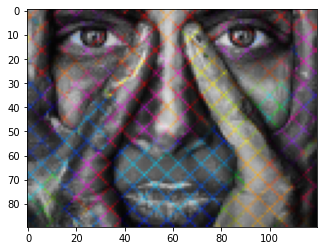

In [ ]:
#input images
y = np.zeros((19,90,120,3))
image = mpimg.imread('/content/images/the_shoe_resized.png')
img = image[:,:,0:3]
plt.imshow(img)

y[0,:,:,:] = img
print(np.max(img))

image = mpimg.imread('/content/images/the_dress_resized.png')
img = image[:,:,0:3]
plt.imshow(img)

y[1,:,:,:] = img
print(np.max(img))


#colored face
image = mpimg.imread('/content/images/Image_by_Alexander_Ivanov_from_pixabay_ar_s.jpg')
img = image[:,:,0:3]/255
plt.imshow(img)

y[2,:,:,:] = img
print(np.max(img))

#louvre
image = mpimg.imread('/content/images/Edi_Nugraha_s.jpg')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)

y[3,:,:,:] = img
print(np.max(img))
#bulding
image = mpimg.imread('/content/images/Michael_Gaida_s.jpg')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)

y[4,:,:,:] = img
print(np.max(img))
#german-museum
image = mpimg.imread('/content/images/german-museum-by-Alexander-Ivanov_s.jpg')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)

y[5,:,:,:] = img
print(np.max(img))
#red squere
image = mpimg.imread('/content/images/red.png')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)

y[6,:,:,:] = img
print(np.max(img))

image = mpimg.imread('/content/images/cubeillusion_s.png')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)

y[7,:,:,:] = img
print(np.max(img))

image = mpimg.imread('/content/images/blue_cube_s.png')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)

y[8,:,:,:] = img
print(np.max(img))


image = mpimg.imread('/content/images/yellow_cube_s.png')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)

y[9,:,:,:] = img
print(np.max(img))

image = mpimg.imread('/content/images/colored_face_grid_s.png')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)

y[10,:,:,:] = img
print(np.max(img))


image = mpimg.imread('/content/images/red_grid_s.png')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)

y[11,:,:,:] = img
print(np.max(img))

image = mpimg.imread('/content/images/red_grid_s_sat_4_size_50px.png')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)
y = np.array(y)
y[12,:,:,:] = img
print(np.max(img))

image = mpimg.imread('/content/images/colored_face_grid_s_sat_4_size50px.png')
img = image[:,:,0:3]/np.max(image)
plt.imshow(img)
y[13,:,:,:] = img
print(np.max(img))





In [ ]:
def convert2opp_laplace(y):
  H = y.shape[1]
  W = y.shape[2]
  opp_images_lap = np.zeros((y.shape[0],y.shape[1],y.shape[2],4))
  
  j = np.arange(1,H-1,1) 
  k = np.arange(1,W-1,1)
  for i in range(y.shape[0]): 
    img_opp = rgb2opp(1*y[i])
    
    for c in range(3): 
      opp_images_lap[i,:,:,c] = -1*scipy.ndimage.filters.laplace(img_opp[:,:,c],mode = 'nearest')      
     
  return opp_images_lap

def sample_color(y,s):
  img_opp_s = np.zeros_like(y)
  for i in range(y.shape[0]):
    img_opp = rgb2opp(1*y[i])    
    
    img_opp_s[i,::s,::s,:] = img_opp[::s,::s,:]
    img_opp_s[i,::s,::s,2] = img_opp[:,:,2]
  return img_opp_s[:,:,:,0],img_opp_s[:,:,:,1],img_opp_s[:,:,:,2]

#prepare the inputs, and convert to 1D vector

# DO pathway 
opp_images = convert2opp_laplace(y)
print(opp_images.shape)
RG_DO = 10*np.reshape(opp_images[:,:,:,0],(opp_images[:,:,:,0].shape[0],1, -1))
BY_DO = 10*np.reshape(opp_images[:,:,:,1],(opp_images[:,:,:,1].shape[0],1, -1))
gray_on_off =10*np.reshape(opp_images[:,:,:,2],(opp_images[:,:,:,2].shape[0],1, -1))

print(RG_DO.shape)
print(BY_DO.shape)
print(gray_on_off.shape)


# SO pathway
RG,BY,Gray = sample_color(y,1)

RG = 10*np.reshape(RG,(RG.shape[0],1, -1))
BY = 10*np.reshape(BY,(BY.shape[0],1, -1))
Gray = 10*np.reshape(Gray,(Gray.shape[0],1, -1))
print(RG.shape)
print(BY.shape)
print(Gray.shape)


(19, 90, 120, 4)
(19, 1, 10800)
(19, 1, 10800)
(19, 1, 10800)
(19, 1, 10800)
(19, 1, 10800)
(19, 1, 10800)


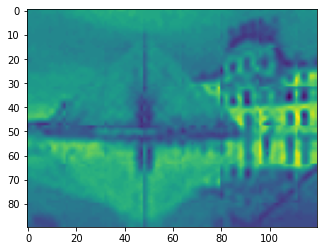

In [ ]:
plt.imshow(RG[3])

In [ ]:

present_time = 0.3
n = h*w

net = nengo.Network(label="NetColor")
with net:
  gray_input_l = nengo.Node(nengo.processes.PresentInput(
      Gray, presentation_time=present_time
  ))
  gray_input_on_off = nengo.Node(nengo.processes.PresentInput(
      gray_on_off, presentation_time=present_time
  ))
  RG_input = nengo.Node(nengo.processes.PresentInput(
      RG_DO, presentation_time=present_time
  ))

  BY_input = nengo.Node(nengo.processes.PresentInput(
      BY_DO, presentation_time=present_time
  ))

  RG_input_so = nengo.Node(nengo.processes.PresentInput(
      RG, presentation_time=present_time
  ))

  BY_input_so = nengo.Node(nengo.processes.PresentInput(
      BY, presentation_time=present_time
  ))
  
  
  gray_filling_in = LaplaceNet(20)
  RG_filling_in   = LaplaceNet(20)
  BY_filling_in   = LaplaceNet(20)
  
  nengo.Connection(gray_input_on_off,gray_filling_in.input)
  nengo.Connection(RG_input, RG_filling_in.input)
  nengo.Connection(BY_input, BY_filling_in.input)

  color_filling_in_so = color_network()
  nengo.Connection(RG_input_so, color_filling_in_so.O1)
  nengo.Connection(BY_input_so, color_filling_in_so.O2)
  nengo.Connection(gray_input_l, color_filling_in_so.O3)
  

 
  gray_do_out = nengo.Probe(gray_filling_in.output,synapse=0.05)
  RG_do_out = nengo.Probe(RG_filling_in.output,synapse=0.05)
  BY_do_out = nengo.Probe(BY_filling_in.output,synapse=0.05)
  RG_so_out = nengo.Probe(color_filling_in_so.diff1.output, synapse=0.05)
  BY_so_out = nengo.Probe(color_filling_in_so.diff2.output, synapse=0.05)
  gray_so_out = nengo.Probe(color_filling_in_so.diff3.output, synapse=0.05)
print(net.n_neurons)    


/usr/local/lib/python3.7/dist-packages/nengo/node.py:63: UserWarning: 'Node.size_out' is being overwritten with 'Node.size_in' since 'Node.output=None'
  "'Node.size_out' is being overwritten with "


777600


In [ ]:
import nengo_ocl
runtime = 14 * present_time
with nengo_ocl.Simulator(net) as sim:
#with nengo.Simulator(nengo_converter.net) as sim:
    sim.run(runtime)

No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


/usr/local/lib/python3.7/dist-packages/nengo_ocl/simulator.py:205: UserWarning: This version of `nengo_ocl` has not been tested with your `nengo` version (3.2.0). The latest fully supported version is 3.1.0
  "supported version is %s" % (nengo.__version__, latest_nengo_version)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [ ]:
from scipy.io import savemat
Z = np.zeros((18,90,120,6))
for i in range(13):
  m = int((i)*(present_time*1000)+((present_time*1000)-1))
  gray_hp = np.reshape(sim.data[gray_do_out][m],(h,w))
  gray_lp = np.reshape(sim.data[gray_so_out][m],(h,w))
  o1_hp = np.reshape(sim.data[RG_do_out][m],(h,w))
  o2_hp = np.reshape(sim.data[BY_do_out][m],(h,w))
  o1_lp = np.reshape(sim.data[RG_so_out][m],(h,w))
  o2_lp = np.reshape(sim.data[BY_so_out][m],(h,w))
  Z[i,:,:,0] = gray_hp
  Z[i,:,:,1] = gray_lp
  Z[i,:,:,2] = o1_hp
  Z[i,:,:,3] = o2_hp
  Z[i,:,:,4] = o1_lp
  Z[i,:,:,5] = o2_lp

np.save('color_output', Z)
temp = np.load('color_output.npy')
savemat('lp_color_output.mat', {"color_output":temp})

In [ ]:
# save and display results
os.makedirs('results',exist_ok=True)

for i in range(13):
  m = int((i)*(present_time*1000)+((present_time*1000)-1))
  plt.figure()
  plt.imshow(y[m//int(present_time*1000),:,:,:])
  plt.title('Original image')
  for alpha_i in [1,0.5]:    
    beta_i = 1- alpha_i
    os.makedirs('results/'+str(alpha_i),exist_ok=True)
    for alpha_c in [1,0.7,0.5,0]:    
      beta_c = 1- alpha_c    
      
      I = alpha_i*(np.reshape(sim.data[gray_do_out][m],(h,w))) + beta_i*np.reshape(sim.data[gray_so_out][m],(h,w))
      I = I-np.min(I) 
      gray = 500*I/np.max(I)
  
      o1 = 100*(beta_c*sim.data[RG_so_out][m]+alpha_c*sim.data[RG_do_out][m])
      o2 = 100*(beta_c*sim.data[BY_so_out][m]+alpha_c*sim.data[BY_do_out][m])
      
      out_img = np.stack((np.reshape(o1,(h,w)),np.reshape(o2,(h,w)),gray),axis=-1)
      plt.figure()
      plt.imshow(opp2rgb(out_img)/500)
      plt.title('Predicted image '+'alpha_i: '+str(alpha_i)+' alpha_c: '+str(alpha_c))
      
      im = np.maximum(opp2rgb(out_img)/500,0)
      im = np.minimum(im,1)
      matplotlib.image.imsave('/content/results/' + str(alpha_i)+'/intesity_alpaha_'+str(alpha_i)+ '_color_alpha_'+str(alpha_c) +'_image_' + str(i) +'.png', im)


  
  